## Modeling

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read in the data from the .pkl
df = pd.read_pickle("./data/baseline_fe_data.pkl")

num_cols = list(df._get_numeric_data().columns)
cat_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
target = ['is_bad']
num_cols.remove('is_bad')

cols_to_keep = ['is_bad', 'revol_bal', 'debt_to_income', 'revol_util', 'annual_inc', 'total_acc', 'cr_line_yrs', 'open_acc', 'emp_length', 'inq_last_6mths']
df = df[cols_to_keep]
num_cols = list(df._get_numeric_data().columns)
cat_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
target = ['is_bad']
num_cols.remove('is_bad')

In [12]:
#df[cat_cols].dtypes
df.dtypes

is_bad              int64
revol_bal           int64
debt_to_income    float64
revol_util        float64
annual_inc        float64
total_acc         float64
cr_line_yrs       float64
open_acc          float64
emp_length          int64
inq_last_6mths    float64
dtype: object

In [13]:
#df[num_cols].dtypes

In [14]:
df[target].dtypes

is_bad    int64
dtype: object

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   is_bad          10000 non-null  int64  
 1   revol_bal       10000 non-null  int64  
 2   debt_to_income  10000 non-null  float64
 3   revol_util      10000 non-null  float64
 4   annual_inc      10000 non-null  float64
 5   total_acc       10000 non-null  float64
 6   cr_line_yrs     10000 non-null  float64
 7   open_acc        10000 non-null  float64
 8   emp_length      10000 non-null  int64  
 9   inq_last_6mths  10000 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 781.4 KB


In [16]:
#def zip_region(x):
#    return x[1:3]
#
#df['zip_region'] = df.zip_code.apply(zip_region)
#df.drop('zip_code', axis=1, inplace=True)

In [17]:
#df.info()

## Log transformation of numeric parameters

In [18]:
def log_trans(x):
    return np.log(x+1)

temp_cols = num_cols.copy()
temp_cols.remove('debt_to_income')
temp_cols.remove('revol_util')

df[temp_cols] = df[temp_cols].apply(log_trans)
df[temp_cols]

,revol_bal,annual_inc,total_acc,cr_line_yrs,open_acc,emp_length,inq_last_6mths
0,9.399969,10.819798,3.806662,7.597396,2.772589,2.397895,0.000000
1,9.221775,10.576866,1.791759,7.603898,1.609438,0.693147,1.098612
2,4.406719,11.082158,2.197225,7.586296,1.609438,1.609438,0.000000
3,9.213436,10.959558,3.178054,7.592366,1.945910,2.397895,0.000000
4,9.281823,10.819878,3.091042,7.600902,2.197225,2.397895,1.609438
...,...,...,...,...,...,...,...
9995,8.204398,11.101206,2.397895,7.601902,2.197225,1.791759,0.693147
9996,8.811354,10.165890,2.564949,7.601402,2.197225,0.693147,0.693147
9997,9.336709,10.775450,2.890372,7.595890,2.302585,2.197225,0.000000
9998,9.750220,11.156265,3.332205,7.600902,2.302585,1.945910,1.098612


In [20]:
# Create a feature engineered profile report
import pandas_profiling
profile_file = './ls_profile_report_fe_not_cat.html'

override = False
if not os.path.exists(profile_file) or override:    
    profile = df.profile_report(title='Feature Engineered Lending Club Data Profile Report')
    profile.to_file(output_file=profile_file)

#### Label Encode and One-Hot Encode Categorical Variables
- NOTE: I may need to reduce the dimensions after the one-hot encoding, but we will see how this goes first

In [21]:
from sklearn import preprocessing

count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count)

0 columns were label encoded.


In [22]:
df = pd.get_dummies(df)
print(df.shape)

(10000, 10)


In [188]:
# Save out the data with basic feature engineering
#df.to_pickle("./data/non_standard_explore_data.pkl")

## Split out the data

In [23]:
from sklearn.model_selection import train_test_split
seed = 20

# Try just using a train/test split at first without sorting the values by time (I don't know how truly time-based this model will be)
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_bad',axis=1), df['is_bad'], test_size=0.20, random_state=seed)

print("Training Distribution of is_bad:")
print(len(y_train[y_train==1])/len(y_train))

print()
print("Test Distribution of is_bad:")
print(len(y_test[y_test==1])/len(y_test))

Training Distribution of is_bad:
0.1285

Test Distribution of is_bad:
0.1335


## Standard scale the numerical data

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [25]:
# See how much this boosts the correlations
corr = df.corr()['is_bad'].sort_values()

# Display correlations
print('Most Positive Correlations with "is_bad"')
print(20*"-")
print(corr.tail(10))
print()
print('Most Negative Correlations with "is_bad"')
print(20*"-")
print(corr.head(10))

Most Positive Correlations with "is_bad"
--------------------
annual_inc       -0.069336
total_acc        -0.067703
emp_length       -0.036741
open_acc         -0.025441
revol_bal         0.004982
inq_last_6mths    0.023166
cr_line_yrs       0.029531
debt_to_income    0.029873
revol_util        0.087797
is_bad            1.000000
Name: is_bad, dtype: float64

Most Negative Correlations with "is_bad"
--------------------
annual_inc       -0.069336
total_acc        -0.067703
emp_length       -0.036741
open_acc         -0.025441
revol_bal         0.004982
inq_last_6mths    0.023166
cr_line_yrs       0.029531
debt_to_income    0.029873
revol_util        0.087797
is_bad            1.000000
Name: is_bad, dtype: float64


In [26]:
num_cols = list(df._get_numeric_data().columns)
cat_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
target = ['is_bad']
num_cols.remove('is_bad')

## Upsample the training data

In [27]:
# You need to try and balance the classes within the training set
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=seed)
x_train_r, y_train_r = sm.fit_resample(X_train, y_train)

## Try 4 initial models: LR Classifier, RF Classifier, LightGBM Classifier, SVM Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split

In [29]:
def plot_roc(y_test, y_pred, Title=''):
    # Compute ROC curve and ROC area for each class
    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Compute micro-average ROC curve and ROC area
    #fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    #roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example {0}'.format(Title))
    plt.legend(loc="lower right")
    plt.show()

In [30]:
# Start with simple logistic regression classifier for second baseline attempt
clf_lr = LogisticRegression(C = 0.001, random_state=seed)
clf_lr.fit(x_train_r, y_train_r)

LogisticRegression(C=0.001, random_state=20)

In [31]:
ypred = clf_lr.predict(X_test)
score = roc_auc_score(y_test, ypred)

print(f"Test AUC score: {score}")
print(classification_report(y_test, ypred))

print("Min accuracy to beat for just random guessing in the TEST set:")
print(len(y_test[y_test == 0])/len(y_test))

Test AUC score: 0.570989235181355
              precision    recall  f1-score   support

           0       0.90      0.56      0.69      1733
           1       0.17      0.58      0.26       267

    accuracy                           0.56      2000
   macro avg       0.53      0.57      0.48      2000
weighted avg       0.80      0.56      0.63      2000

Min accuracy to beat for just random guessing in the TEST set:
0.8665


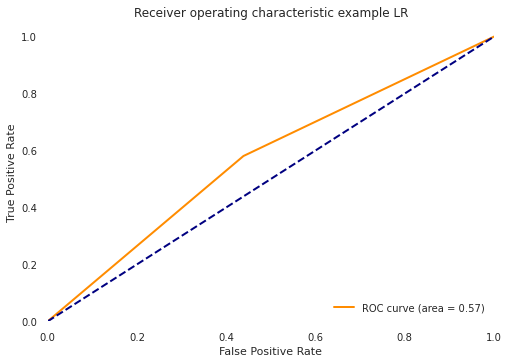

In [32]:
plot_roc(y_test, ypred, 'LR')

In [33]:
clf_rf = RandomForestClassifier(n_estimators=200, 
                                random_state=seed,
                                min_samples_split=2,
                                min_samples_leaf=50,
                                oob_score=True)
clf_rf.fit(x_train_r, y_train_r)

RandomForestClassifier(min_samples_leaf=50, n_estimators=200, oob_score=True,
                       random_state=20)

In [34]:
ypred = clf_rf.predict(X_test)
score = roc_auc_score(y_test, ypred)

print(f"Test AUC score: {score}")
print(classification_report(y_test, ypred))

print("Min accuracy to beat for just random guessing in the TEST set:")
print(len(y_test[y_test == 0])/len(y_test))

Test AUC score: 0.5541936543544459
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1733
           1       0.21      0.27      0.23       267

    accuracy                           0.77      2000
   macro avg       0.54      0.55      0.55      2000
weighted avg       0.79      0.77      0.78      2000

Min accuracy to beat for just random guessing in the TEST set:
0.8665


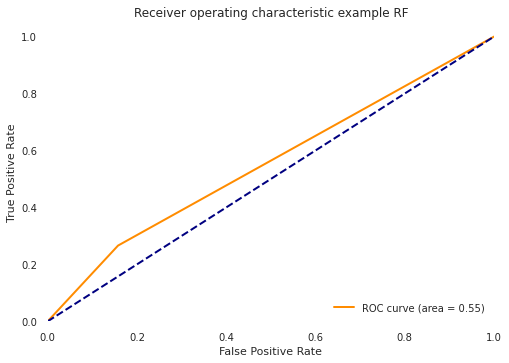

In [35]:
plot_roc(y_test, ypred, 'RF')

In [36]:
import lightgbm as lgb

dtrain = lgb.Dataset(x_train_r, label=y_train_r)
dvalid = lgb.Dataset(X_test, label=y_test)

param = {'num_leaves': 32, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=20, verbose_eval=False)

In [37]:
ypred = bst.predict(X_test)
#ypred_thresh = [1 if x >= 0.5 else 0 for x in ypred]

score = roc_auc_score(y_test, ypred)

print(f"Test AUC score: {score}")
print(classification_report(y_test, np.around(ypred, 0)))

print("Min accuracy to beat for just random guessing in the TEST set:")
print(len(y_test[y_test == 0])/len(y_test))

Test AUC score: 0.6213738164858842
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1733
           1       0.75      0.03      0.06       267

    accuracy                           0.87      2000
   macro avg       0.81      0.52      0.50      2000
weighted avg       0.85      0.87      0.81      2000

Min accuracy to beat for just random guessing in the TEST set:
0.8665


In [ ]:
plot_roc(y_test, ypred, 'LGBM')

In [214]:
from sklearn.svm import SVC

clf_svm = SVC(C=0.1)
clf_svm.fit(x_train_r, y_train_r)

SVC(C=0.1)

In [215]:
ypred = clf_svm.predict(X_test)
#ypred_thresh = [1 if x >= 0.5 else 0 for x in ypred]

score = roc_auc_score(y_test, ypred)

print(f"Test AUC score: {score}")
print(classification_report(y_test, np.around(ypred, 0)))

print("Min accuracy to beat for just random guessing in the TEST set:")
print(len(y_test[y_test == 0])/len(y_test))

Test AUC score: 0.6259706382601669
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1733
           1       0.22      0.55      0.32       267

    accuracy                           0.68      2000
   macro avg       0.57      0.63      0.55      2000
weighted avg       0.82      0.68      0.73      2000

Min accuracy to beat for just random guessing in the TEST set:
0.8665


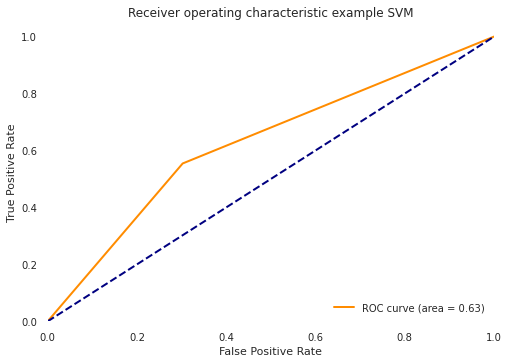

In [216]:
plot_roc(y_test, ypred, 'SVM')

### Gradient Boosted Methods + Kfold Cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier

kfold = KFold(n_splits=10)

clf_lgb = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
n_scores = cross_val_score(clf_lgb, x_train_r, y_train_r, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#clf_lgb.fit(x_train_r, y_train_r)

In [ ]:
for train_indices, test_indices in kfold.split(x_train_r):
    print('Train: %s | test: %s' % (train_indices, test_indices))

In [ ]:
n_scores

In [ ]:
#ypred = clf_lgb.predict(validation[feature_cols])
#score = metrics.roc_auc_score(validation['is_bad'], ypred)

ypred = clf_lgb.predict(X_test)
score = metrics.roc_auc_score(y_test, ypred)

print(f"Test AUC score: {score}")
print(metrics.classification_report(y_test, ypred))

print("Min accuracy to beat for just random guessing in the TEST set:")
print(len(validation[validation.is_bad == 0])/len(validation))